In [1]:
import sys
import csv
import warnings
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Example 1

- 120 children participated in the study, with 60 children assigned to the treatment (trt = 1), and 60 assigned to control (trt = 0). 


- There were some issues with noncompliance, and not every student in the treatment group received the treatment (rectrt = 1). 


- The outcomes of interest are height, weight and IQ scores in 2012. 
- In addition to the outcome variables, you have also been given pre-treatment scores in 2011 as well as a variety of demographic covariates (eg., living in urban or suburban). 
- The health outcome scores have been normalized and so are in standard deviation units. All of the variables in the dataset are labeled.  


# 1. Upload data

In [2]:
#Locate file
!ls

 Fixed_random.ipynb	   'WDI-subset5y_extended 2014 fall.xlsx'
 Instrumental-Copy1.ipynb   height_2012_csvfile.csv
 RCT_2sls.ipynb		    rct_data.dta


In [3]:
#Upload file
file = 'rct_data.dta'
df = pd.read_stata(file)
df.head(3)

,ID,trt,rectrt,height_2012,height_2011,weight_2012,weight_2011,IQ_2012,IQ_2011,urban,suburban
0,1,1,1,6,84,60,71,82,61,0,0
1,2,1,1,29,32,72,88,86,75,1,1
2,3,1,1,69,37,63,97,23,30,0,1


In [4]:
#Check variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           120 non-null    int16
 1   trt          120 non-null    int8 
 2   rectrt       120 non-null    int8 
 3   height_2012  120 non-null    int8 
 4   height_2011  120 non-null    int8 
 5   weight_2012  120 non-null    int8 
 6   weight_2011  120 non-null    int8 
 7   IQ_2012      120 non-null    int8 
 8   IQ_2011      120 non-null    int8 
 9   urban        120 non-null    int8 
 10  suburban     120 non-null    int8 
dtypes: int16(1), int8(10)
memory usage: 2.3 KB


# 2. EDA

## 2.1 Descriptive statistics

In [5]:
df.describe()

,ID,trt,rectrt,height_2012,height_2011,weight_2012,weight_2011,IQ_2012,IQ_2011,urban,suburban
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.00000,120.000000
mean,60.500000,0.491667,0.433333,49.300000,53.991667,53.166667,52.250000,53.850000,52.808333,0.55000,0.441667
std,34.785054,0.502027,0.497613,28.211268,27.823120,27.105252,26.237522,28.327511,29.661478,0.49958,0.498668
min,1.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,0.000000,1.000000,0.00000,0.000000
25%,30.750000,0.000000,0.000000,25.000000,30.000000,30.750000,33.000000,31.750000,27.750000,0.00000,0.000000
50%,60.500000,0.000000,0.000000,50.000000,55.500000,56.500000,53.000000,55.500000,53.500000,1.00000,0.000000
75%,90.250000,1.000000,1.000000,73.250000,78.000000,76.250000,72.750000,79.250000,81.250000,1.00000,1.000000
max,120.000000,1.000000,1.000000,99.000000,100.000000,99.000000,100.000000,100.000000,100.000000,1.00000,1.000000


## 2.2 Plot distribution of treated vs. non-treated

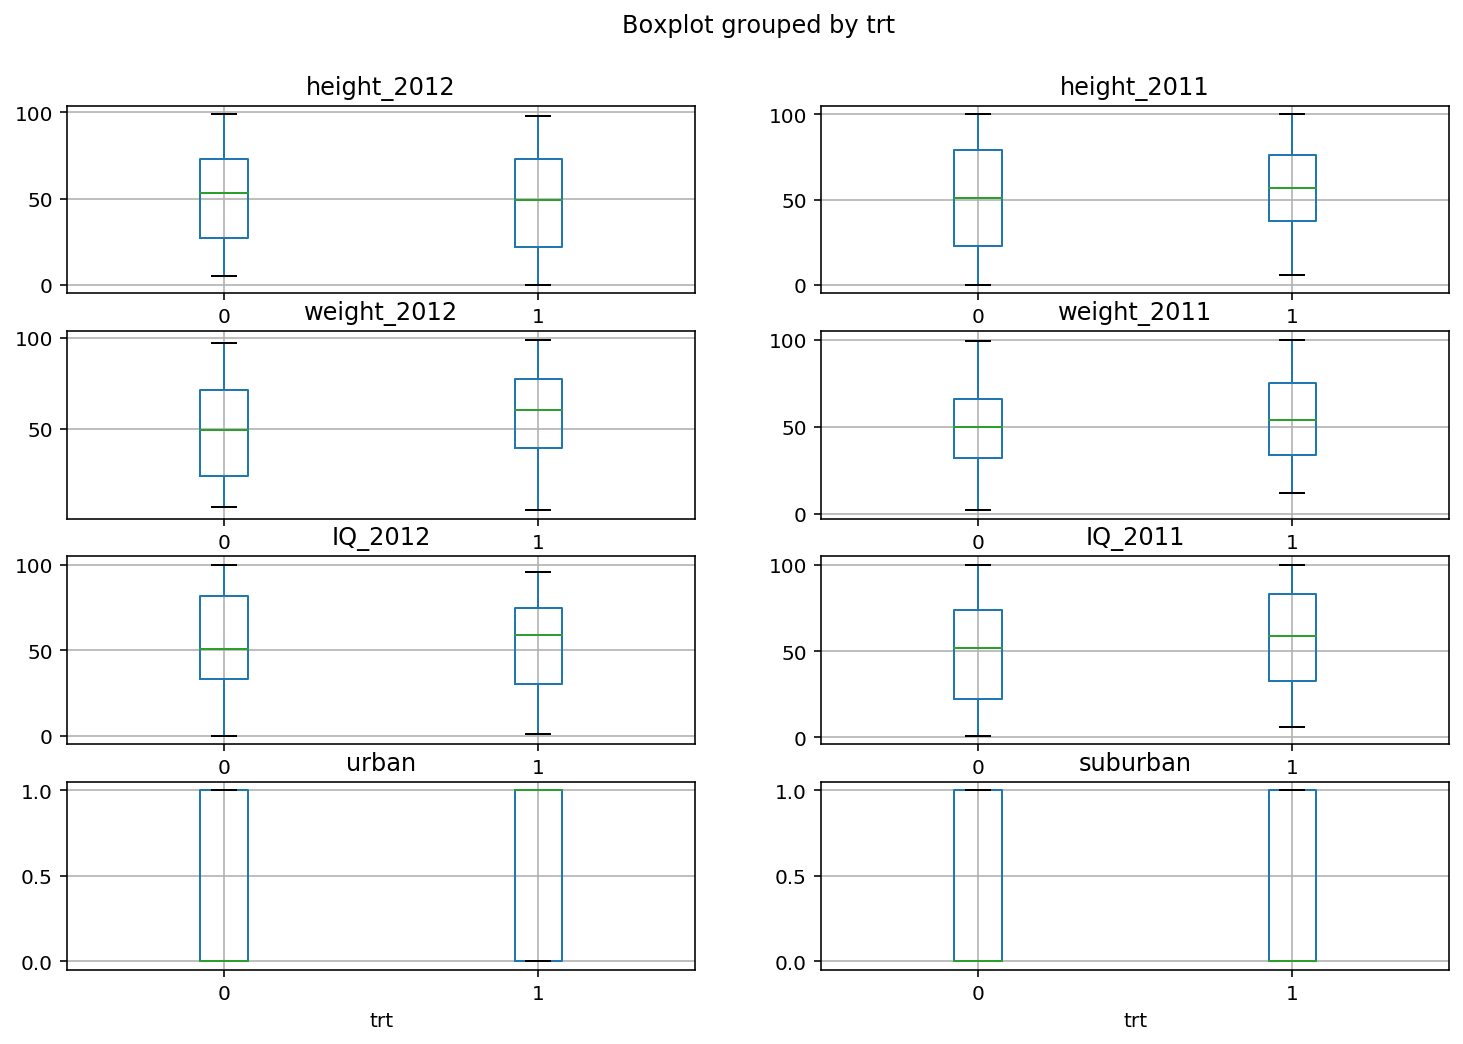

In [6]:
def summary_plot_2periods(boxplot, colnames):
    fig, axes = plt.subplots(len(colnames) // 2, 2, figsize=(12, 8))
    k = 0
    for i in range(len(colnames) // 2):
        for j in range(2):
            if boxplot:
                df.boxplot(column=colnames[k], by='trt', ax=axes[(i, j)])
            else:
                sns.violinplot('trt', colnames[k], data=df, ax=axes[(i, j)])
            k += 1
colnames = ['height_2012', 'height_2011', 'weight_2012', 'weight_2011', 'IQ_2012', 'IQ_2011', 'urban', 'suburban']
summary_plot_2periods(boxplot=True, colnames=colnames)

# 3. Preprocess data

120 children participated in the study, with 60 children assigned to the treatment (trt = 1), and 60 assigned to control (trt = 0). There were some issues with noncompliance, and not every student in the treatment group received the treatment (rectrt = 1). 

- The outcomes of interest are height, weight and IQ scores in 2012. 
    - Y = height, weight, IQ
    
    
- Pre-treatment scores in 2011 as well as a variety of demographic covariates (eg., living in urban or suburban). 
    - X 2011, suburban vs. urban 
    - The health outcome scores have been normalized and so are in standard deviation units. 
    - All of the variables in the dataset are labeled.  

# 3.1 Constructing vectors of Y (label), and X(regressors)

- Iterate data to create 3 seperate models 
    Y = height, weight, IQ

In [7]:
file = 'rct_data.dta' #DTA filename
df = pd.read_stata(file) #Import data from the top to be save
y_list = ['height_2012', 'weight_2012', 'IQ_2012'] #Y variables
lagged_DV = [sub.replace('2012', '2011') for sub in y_list] #Lagged Y-vars  

for idx, (DV, lagged) in enumerate(zip(y_list, lagged_DV)): #Iterate over y_list and lagged_DV
    x = df[['trt' ,'urban', str(lagged)]] #Set independent variables + each respective lagged var
    x = sm.add_constant(x) #Add constant to indepdent variables
    y = df[[DV]] #Y-variable
    print('Model '+str(idx+1)+': y='+str(y.columns.values), 'x='+str(x.columns.values)) #Print each model that will be used

Model 1: y=['height_2012'] x=['const' 'trt' 'urban' 'height_2011']
Model 2: y=['weight_2012'] x=['const' 'trt' 'urban' 'weight_2011']
Model 3: y=['IQ_2012'] x=['const' 'trt' 'urban' 'IQ_2011']


# 4. Baseline regressions

## 4.1 Exploring non-compliant

### 4.1.1 Approaches to non-compliant
1. `Per protocal:` Examine only participants who were compliant
2. `As treated:` Examined as they were treated
3. `Intention to treat:` Examined as they were assigned

### 4.1.2 Exploring non-compliars in data set

In [8]:
mask = (df.trt==1) & (df.rectrt==0)

In [9]:
df.loc[mask]

,ID,trt,rectrt,height_2012,height_2011,weight_2012,weight_2011,IQ_2012,IQ_2011,urban,suburban
52,53,1,0,81,73,36,41,25,82,1,1
53,54,1,0,20,78,46,72,21,69,1,0
54,55,1,0,23,46,51,16,38,100,0,0
55,56,1,0,52,28,18,42,95,93,0,1
56,57,1,0,40,79,84,82,47,69,0,1
57,58,1,0,48,91,87,31,89,6,1,0
58,59,1,0,27,6,69,64,89,61,1,1


### 4.1.2 Create Non-compliant dummy

In [10]:
df['Non_compliant'] = pd.get_dummies(mask, drop_first=True)

In [11]:
pct_noncomplier = df['Non_compliant'].mean()
print('{:.2f}% of treated were non-complient'.format(pct_noncomplier*100))

5.83% of treated were non-complient


## 4.2 Is RCT balanced?

### 4.2.1 T-test on means

In [12]:
means = ['height_2011', 'weight_2011', 'IQ_2011', 'urban', 'suburban']

for mean in means:
    non_comp = df.loc[df['trt']==1, mean].values
    complier = df.loc[df['trt']==0, mean].values
    #print(stats.ttest_ind(non, complier))
    tval, pval = stats.ttest_ind(non_comp, complier)
    if pval>.01:
            print('Fail to reject, P-val:'+str(round(pval,2))+'\n For '+ str(mean)+ ' we cannot conclude there is a difference between treated and un-treated means')

Fail to reject, P-val:0.44
 For height_2011 we cannot conclude there is a difference between treated and un-treated means
Fail to reject, P-val:0.43
 For weight_2011 we cannot conclude there is a difference between treated and un-treated means
Fail to reject, P-val:0.13
 For IQ_2011 we cannot conclude there is a difference between treated and un-treated means
Fail to reject, P-val:0.2
 For urban we cannot conclude there is a difference between treated and un-treated means
Fail to reject, P-val:0.98
 For suburban we cannot conclude there is a difference between treated and un-treated means


## 4.3 Baseline regression
### Intention to treat (ITT) regressions: 
`Intention to treat:` Examined as they were assigned

In [13]:
y_list = ['height_2012', 'weight_2012', 'IQ_2012'] #Y variables
lagged_DV = [sub.replace('2012', '2011') for sub in y_list] #Lagged Y-vars
for idx, (DV, lagged) in enumerate(zip(y_list, lagged_DV)): #Iterate over y_list
    x = df[['trt' ,'urban', str(lagged)]]
    x = sm.add_constant(x)
    y = df[[DV]]
    baseline = sm.OLS(y, x.values).fit() #OLS
    print(baseline.summary())#Print summary of OLS
    
    '''Code to save a csv file for regressions'''
    #f = open(str(DV)+'_csvfile.csv','w')
    #f.write(baseline.summary().as_csv())
    #f.close()
    '''Code to show scatter plots of fitted values'''
    #plt.scatter(baseline.fittedvalues, baseline.resid) #Plot residuals
    #plt.axhline(0, linestyle=':', color='orange') #Add line
    #plt.title('Model '+str(idx+1)+ ' Residuals') #Title
    #plt.show() #Show plot
    print('\n \n \n')#Space between tables

                            OLS Regression Results                            
Dep. Variable:            height_2012   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.323
Date:                Mon, 02 Mar 2020   Prob (F-statistic):             0.0787
Time:                        16:05:11   Log-Likelihood:                -567.04
No. Observations:                 120   AIC:                             1142.
Df Residuals:                     116   BIC:                             1153.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.1789      6.729      9.241      0.0

## 4.4 Two-stage least-square regressions (Instrumental variable)
## Late regression

- [Using the "Linear Models" Library](https://bashtage.github.io/linearmodels/doc/iv/index.html)
    - [Examples of 2SLS in linear models](https://bashtage.github.io/linearmodels/doc/iv/examples/basic-examples.html)
    - [More examples](https://bashtage.github.io/linearmodels/doc/iv/examples/advanced-examples.html)

In [14]:
from linearmodels.iv import IV2SLS

In [15]:
instrument = df[['rectrt']]
endogenous = df[['trt']]

y_list = ['height_2012', 'weight_2012', 'IQ_2012'] #Y variables
lagged_DV = [sub.replace('2012', '2011') for sub in y_list] #Lagged Y-vars
instrument = df[['trt']]
endogenous = df[['rectrt']]

for idx, (DV, lagged) in enumerate(zip(y_list, lagged_DV)): #Iterate over y_list
    x = df[['urban', str(lagged)]]
    x = sm.add_constant(x)
    y = df[[DV]]
    IV = IV2SLS(y, x, endogenous, instrument).fit()
    print(IV)
    print('\n \n \n')#Space between tables



                          IV-2SLS Estimation Summary                          
Dep. Variable:            height_2012   R-squared:                      0.0554
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0310
No. Observations:                 120   F-statistic:                    7.8769
Date:                Mon, Mar 02 2020   P-value (F-stat)                0.0486
Time:                        16:05:15   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           62.179     6.1334     10.138     0.0000      50.157      74.200
urban           0.8395     5.0329     0.1668    